# Edge detection:

The follwing code takes an image of specficed width and height and outputs a matrix of ones and zeros corresponding to the image's edges


# Step1: Run your edge detection on your faviorate image. The edge matrix will be stored in "np_img"


25 objects were found in this image.


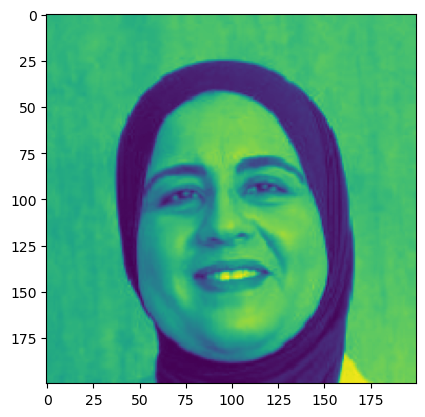

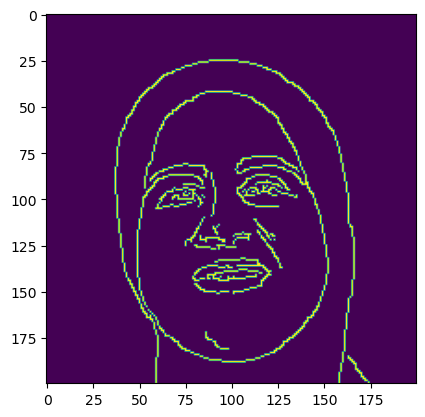

In [1]:
# import the necessary packages

from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
#import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from ipywidgets import interact, IntSlider, Checkbox
import sys
import math
from PIL import Image, ImageDraw

height=200
width=200

image = cv2.imread("face.png")
image = cv2.resize(image, (width,height)) 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 10)

edged = cv2.Canny(gray, 170, 100)

# find the contours in the edged image
contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_copy = image.copy()
# draw the contours on a copy of the original image
cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 1)
print(len(contours), "objects were found in this image.")

imgplot = plt.imshow(gray)
plt.show()

imgplot = plt.imshow(edged)
plt.show()
cv2.waitKey(0)
np_img = np.asarray(edged)
np_img[np_img > 0] = 1
np_img.shape
np_img[height-1]=0
np_img[0]=0
np_img[:,0]=0
np_img[:,width-1]=0

# Line Tracing

The following code takes in the healed edge matrix "u" and outputs the instruction arrays for the two motors


In [2]:
def line_tracer2(u):
    motor1= np.zeros(width*height)
    motor2= np.zeros(width*height)
    starting_row=-1
    starting_colm=-1
    found = False
    for i in range(width):
        if(found):
            break
        for j in range(height):
            if (u[j][i] >0):
                starting_row=j
                starting_colm=i
                found = True
                break
    temp= u.copy()
    Sum = temp.sum()

    index =0
    for i in range(starting_row):
        motor1[index]=1
        motor2[index]=0
        index+=1
    for i in range (starting_colm):
        motor1[index]=0
        motor2[index]=1
        index+=1
    exits=[]
    exits.append(str([starting_row, starting_colm]))
    curr_row = starting_row
    curr_colm = starting_colm
    temp[curr_row][curr_colm]=0
    missed=[]
    
    while (1 in temp):
        if(index%25==0):
            print("processing...", Sum - temp.sum(),"/",Sum)
        List = scan(temp, curr_row, curr_colm)
        if(len(List)>0):
            for i in range(len(List)):
                if (i!=0):
                    missed.append(str([List[i][0], List[i][1]]))
            motor1[index]= List[0][0]-curr_row
            motor2[index]= List[0][1] - curr_colm
            index+=1
            curr_row=List[0][0]
            curr_colm=List[0][1]
            temp[curr_row][curr_colm]=0
        else:
            for i in missed:
                x=int(i.split()[0][1:len(i.split()[0])-1])
                y=int(i.split()[1][0:len(i.split()[1])-1])
                if(temp[x][y]==0):
                    missed.remove(i)
            new_path = find_next2(missed, graph, curr_row, curr_colm)
            missed.remove(new_path[len(new_path)-1])
            for i in new_path:
                curr_row2=int(i.split()[0][1:len(i.split()[0])-1])
                curr_colm2=int(i.split()[1][0:len(i.split()[1])-1])
                motor1[index]= curr_row2-curr_row
                motor2[index]= curr_colm2 - curr_colm
                index+=1
                curr_row=curr_row2
                curr_colm=curr_colm2
                temp[curr_row][curr_colm]=0
                
    print("done!")
    found = False
    for i in range(width):
        if(found):
            break
        for j in range(height):
            if (u[j][width-1-i] >0):
                starting_row=j
                starting_colm=width-1-i
                found = True
                break
    exits.append(str([starting_row, starting_colm]))
    found = False
    for i in range(height):
        if(found):
            break
        for j in range(width):
            if (u[i][j] >0):
                starting_row=i
                starting_colm=j
                found = True
                break
    exits.append(str([starting_row, starting_colm]))
    found = False
    for i in range(height):
        if(found):
            break
        for j in range(width):
            if (u[height-1-i][j] >0):
                starting_row=height-1-i
                starting_colm=j
                found = True
                break
    exits.append(str([starting_row, starting_colm]))
    new_path = find_next2(exits, graph, curr_row, curr_colm)
    
    for i in new_path:
        curr_row2=int(i.split()[0][1:len(i.split()[0])-1])
        curr_colm2=int(i.split()[1][0:len(i.split()[1])-1])
        motor1[index]= curr_row2-curr_row
        motor2[index]= curr_colm2 - curr_colm
        index+=1
        curr_row=curr_row2
        curr_colm=curr_colm2
        

    
    
    
    
    return motor1[0:index], motor2[0:index]

In [3]:
def find_next(temp, curr_row, curr_colm):
    List = list(zip(*np.where(temp == 1)))
    min_distance=10000
    new_row=-1
    new_colm=-1
    for i in List:
        distance= np.sqrt(abs(curr_row - i[0])**2 + abs(curr_colm - i[1])**2)
        if (distance <min_distance):
            min_distance=distance
            new_row = i[0]
            new_colm= i[1]
    return new_row, new_colm, min_distance


In [4]:
def eleminate(temp, rows, colms):
    length=0
    rows2=[]
    colms2=[]

    while (len(rows)>0):
        curr_row=rows.pop(0)
        curr_colm= colms.pop(0)
        if(temp[curr_row-1][curr_colm]==1):#move up
            rows.append(curr_row-1)
            colms.append(curr_colm)
            temp[curr_row-1][curr_colm]=0
            length+=1
            rows2.append(curr_row-1)
            colms2.append(curr_colm)
            
        if(temp[curr_row][curr_colm+1]==1):#move  right
            rows.append(curr_row)
            colms.append(curr_colm+1)
            temp[curr_row][curr_colm+1]=0
            length+=1
            rows2.append(curr_row)
            colms2.append(curr_colm+1)
        if(temp[curr_row+1][curr_colm]==1):#move  down
            rows.append(curr_row+1)
            colms.append(curr_colm)
            temp[curr_row+1][curr_colm]=0
            length+=1
            rows2.append(curr_row+1)
            colms2.append(curr_colm)
        if(temp[curr_row][curr_colm-1]==1):#move  left
            rows.append(curr_row)
            colms.append(curr_colm-1)
            temp[curr_row][curr_colm-1]=0
            length+=1
            rows2.append(curr_row)
            colms2.append(curr_colm-1)

        if(temp[curr_row-1][curr_colm+1]==1):#move up right
            rows.append(curr_row-1)
            colms.append(curr_colm+1)
            temp[curr_row-1][curr_colm+1]=0
            length+=1
            rows2.append(curr_row-1)
            colms2.append(curr_colm+1)

        if(temp[curr_row+1][curr_colm+1]==1):#move  down right
            rows.append(curr_row+1)
            colms.append(curr_colm+1)
            temp[curr_row+1][curr_colm+1]=0
            length+=1
            rows2.append(curr_row+1)
            colms2.append(curr_colm+1)
        if(temp[curr_row+1][curr_colm-1]==1):#move  down left
            rows.append(curr_row+1)
            colms.append(curr_colm-1)
            temp[curr_row+1][curr_colm-1]=0
            length+=1
            rows2.append(curr_row+1)
            colms2.append(curr_colm-1)
        if(temp[curr_row-1][curr_colm-1]==1):#move  up left
            rows.append(curr_row-1)
            colms.append(curr_colm-1)
            temp[curr_row-1][curr_colm-1]=0
            length+=1
            rows2.append(curr_row-1)
            colms2.append(curr_colm-1)
            
    return temp, length,rows2, colms2
    

In [5]:
def shape_info(a):
    temp = a.copy()
    shapes_num=0
    list_rows=[]
    list_colms=[]
    
    starting_row=-1
    starting_colm=-1

    while((1 in temp)):
        shapes_num += 1
        
        found = False
        for i in range(width):
            if(found):
                break
            for j in range(height):
                if (temp[j][i] >0):
                    starting_row=j
                    starting_colm=i
                    found = True
                    break
        
        
            
        temp[starting_row,starting_colm]=0
        temp, length, rows, colms = eleminate(temp.copy(), [starting_row],[starting_colm])
        rows.append(starting_row)
        colms.append(starting_colm)
        list_rows.append(rows)
        list_colms.append(colms)
        #temp=k
        #print(starting_row)
        #print(starting_colm)
        #print(temp[starting_row][starting_colm])
       # print("shape numer ", shapes_num, " has a length of ", length+1, "pixels at the following coordinates:")
        
        
        #print("rows = ", rows)
        #print("and column = ",colms)
        #print("------------------------------------")
    return list_rows, list_colms, shapes_num
        
        
    #print("found ", shapes_num, " objects.")

In [6]:
def healer(a):
    #temp=a.copy()
    img_array = []
    t=a.copy()
    size = (width,height)
    img_array.append(normalize(t.copy(), de =True))
    
    rows, colms, num_shapes = shape_info(a.copy())
    
    for i in range(num_shapes-1):
        print(i,"/",num_shapes-1,"processing...")
        img_array.append(normalize(t.copy(), de =True))
        rows, colms, _ = shape_info(t.copy())
        temp2 = eleminate(t.copy(), [rows[0][0]], [colms[0][0]])[0]
        min_distance = 10000
        old_r = -1
        old_c=-1
        new_r=-1
        new_c=-1
        img_array.append(normalize(temp2.copy(), de =True))

        for j in range(len(rows[0])):
            new_row, new_colm, new_dist = find_next(temp2,rows[0][j], colms[0][j])
            if(new_dist<min_distance):
                min_distance = new_dist
                old_r = rows[0][j]
                old_c = colms[0][j]
                new_r=new_row
                new_c=new_colm
        if (old_r !=-1):
            shape = [( old_c, old_r), (new_c, new_r)]
            img = Image.new("L", (width,height))
    
            # create line image
            img1 = ImageDraw.Draw(img)  
            
            img1.line(shape, fill ="white", width = 0)
            arr= np.asarray(img)
            arr = normalize(arr)
            img_array.append(normalize(arr.copy(), de =True))
            img_array.append(normalize(arr.copy(), de =True))
            t=normalize(t+arr)

            
            
            
            
    img_array.append(normalize(t.copy(), de =True))  
    img_array.append(normalize(t.copy(), de =True))       

    img_array.append(normalize(t.copy(), de =True))       

    print("done....")
    return t, img_array
            
                
                
            
            
            
            
            
            
    
    

    

In [7]:
def normalize(a, de = False):
    s1=a.shape[0]
    s2=a.shape[1]
    m=np.zeros((s1,s2))
    for i in range(s1):
        for j in range(s2):
            if(a[i][j]>0):
                if(de):
                    m[i][j]=255
                else:
                    m[i][j]=1
    return m 

In [8]:
def creat_graph(u):
    rows, colms, _ = shape_info(u)
    rows=rows[0]
    colms=colms[0]
    graph = {}
    
    for i in range(len(rows)):
        coordinates = str([rows[i], colms[i]])
        edges = {}
        
        if(u[rows[i]-1][colms[i]]==1):#move up
            key = str([rows[i]-1, colms[i]])
            edges[key]=1
        if(u[rows[i]][colms[i]+1]==1):#move right
            key = str([rows[i], colms[i]+1])
            edges[key]=1
        if(u[rows[i]+1][colms[i]]==1):#move down
            key = str([rows[i]+1, colms[i]])
            edges[key]=1
        if(u[rows[i]][colms[i]-1]==1):#move left
            key = str([rows[i], colms[i]-1])
            edges[key]=1
        if(u[rows[i]-1][colms[i]+1]==1):#move up right
            key = str([rows[i]-1, colms[i]+1])
            edges[key]=1
        if(u[rows[i]+1][colms[i]+1]==1):#move down right
            key = str([rows[i]+1, colms[i]+1])
            edges[key]=1
        if(u[rows[i]+1][colms[i]-1]==1):#move down left
            key = str([rows[i]+1, colms[i]-1])
            edges[key]=1
        if(u[rows[i]-1][colms[i]-1]==1):#move up left
            key = str([rows[i]-1, colms[i]-1])
            edges[key]=1
        graph[coordinates]= edges
    return graph

In [9]:
import heapq

def dijkstra(graph, start, end):
    """Find the shortest path between two nodes in a graph."""
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    visited = set()
    previous = {}
    queue = [(0, start)]
    
    while queue:
        (cost, node) = heapq.heappop(queue)
        if node in visited:
            continue
        visited.add(node)
        
        for neighbor, weight in graph[node].items():
            new_cost = distances[node] + weight
            if new_cost < distances[neighbor]:
                distances[neighbor] = new_cost
                previous[neighbor] = node
                heapq.heappush(queue, (new_cost, neighbor))
    
    # Reconstruct the shortest path
    path = []
    node = end
    while node != start:
        path.insert(0, node)
        node = previous[node]
    path.insert(0, start)
    
    return path

In [10]:
def find_next2(missed, graph, curr_row, curr_colm):
    final_path=""
    start = str([curr_row, curr_colm])
    min_distance= 10000
    for i in missed:
        end = i
       # print("printing start: ", start)
        #print("printing end: ", end)
        path = dijkstra(graph, start, end)
        if ((len(path)< min_distance) and start!=end):
            min_distance = len(path)
            final_path = path
    return final_path

In [11]:
def scan(u,i,j):
    List=[]
    if(u[i-1][j]==1):#move up
        List.append([i-1,j])
    if(u[i][j+1]==1):#move right
        List.append([i,j+1])

    if(u[i+1][j]==1):#move down
        List.append([i+1,j])

    if(u[i][j-1]==1):#move left
        List.append([i,j-1])

    if(u[i-1][j+1]==1):#move up right
        List.append([i-1,j+1])

    if(u[i+1][j+1]==1):#move down right
        List.append([i+1,j+1])

    if(u[i+1][j-1]==1):#move down left
        List.append([i+1,j-1])

    if(u[i-1][j-1]==1):#move up left
        List.append([i-1,j-1])
    return List

# Step 2: run healer() on your "np_img". The new edge matrix will be stored in  "u". You may use "img_arry2" for visualization/debuggin purposes.


In [12]:
#process image to have excactly one connected components
u, img_arry2= healer(np_img)

0 / 24 processing...
1 / 24 processing...
2 / 24 processing...
3 / 24 processing...
4 / 24 processing...
5 / 24 processing...
6 / 24 processing...
7 / 24 processing...
8 / 24 processing...
9 / 24 processing...
10 / 24 processing...
11 / 24 processing...
12 / 24 processing...
13 / 24 processing...
14 / 24 processing...
15 / 24 processing...
16 / 24 processing...
17 / 24 processing...
18 / 24 processing...
19 / 24 processing...
20 / 24 processing...
21 / 24 processing...
22 / 24 processing...
23 / 24 processing...
done....


In [71]:
#verify number of component is one
shape_info(u)[2]

1

In [99]:
#show healed image
out=u.copy()
out[out>0]=255
im = Image.fromarray(out)
im.show()

In [28]:
#show orignial input
out=np_img.copy()
out[out>0]=255
im = Image.fromarray(out)
im.show()

# Step 3: Create a graph of the edge matrix "u".


In [13]:
graph = creat_graph(u)

# Step 4: find the path the motors should take to draw the edge matrix "u".



In [14]:
motor1, motor2 = line_tracer2(u)

processing... 6.0 / 1785.0
processing... 31.0 / 1785.0
processing... 56.0 / 1785.0
processing... 81.0 / 1785.0
processing... 106.0 / 1785.0
processing... 131.0 / 1785.0
processing... 156.0 / 1785.0
processing... 223.0 / 1785.0
processing... 254.0 / 1785.0
processing... 266.0 / 1785.0
processing... 281.0 / 1785.0
processing... 306.0 / 1785.0
processing... 331.0 / 1785.0
processing... 356.0 / 1785.0
processing... 392.0 / 1785.0
processing... 408.0 / 1785.0
processing... 433.0 / 1785.0
processing... 461.0 / 1785.0
processing... 484.0 / 1785.0
processing... 507.0 / 1785.0
processing... 532.0 / 1785.0
processing... 557.0 / 1785.0
processing... 601.0 / 1785.0
processing... 604.0 / 1785.0
processing... 629.0 / 1785.0
processing... 651.0 / 1785.0
processing... 652.0 / 1785.0
processing... 673.0 / 1785.0
processing... 695.0 / 1785.0
processing... 716.0 / 1785.0
processing... 745.0 / 1785.0
processing... 770.0 / 1785.0
processing... 795.0 / 1785.0
processing... 815.0 / 1785.0
processing... 845.0

# Step 5 (optional): Create a visualization of the how the image would be cut

In [15]:
img_arry = []
row= 0
colm= 0
img= np.zeros((width,height,3),dtype='uint8')
for i in range(len(motor1)):
    img2= np.zeros((width,height,3),dtype='uint8')
    row=int(row+motor1[i])
    colm=int(colm+motor2[i])
    img2[row][colm] =255
    if (img[row][colm][0]==255):
        if(img[row][colm][1]==255):
            img[row][colm][1]=25
            img[row][colm][2]=25
        else:
            img[row][colm][1]=255
            img[row][colm][2]=255
        
    else:
        img += img2
    #img[img>0]=255
    img_arry.append(img.copy())
img[img>0]=255
for i in range(30):
    img_arry.append(img.copy())
    img_arry.append(img.copy())
    img_arry.append(img.copy())
    img_arry.append(img.copy())
    img_arry.append(img.copy())

    

In [72]:
img2= np.zeros((200,200,3))


In [16]:




images = np.asarray(img_arry, np.uint8)  #change to "img_arry2" for visualization of the "healer()" function

# Set the frame size of the video
frame_size = (600, 600)

# Set the frame rate of the video
frame_rate = 30

# Create a VideoWriter object
video = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*"MJPG"), frame_rate, frame_size)

# Loop through each grayscale image in the NumPy array
for image in images:
    
                
    image = cv2.resize(image, frame_size)

    # Write the image to the video
    video.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Release the video object
video.release()

# Play the video and save it to a file
cap = cv2.VideoCapture("output.avi")
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('output_playback4.avi', fourcc, frame_rate, frame_size)
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        cv2.imshow("Video", frame)
        out.write(frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    else:
        break

# Release the video capture and the video writer and close all windows
cap.release()
out.release()
cv2.destroyAllWindows()

In [17]:
len(motor1)

3228